# Evaluating Gene Correlations - Spinal cord

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


from moscot.problems.time._lineage import TemporalProblem

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path="/home/mgander/moscot-framework_reproducibility/data/mouse_temporal"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

In [3]:
ct='E8.25:Spinal cord'
i=11

ts0=ts[i]
ts1=ts[i+1]

In [4]:
gT=np.load(f"{Path}/TOME_transport_maps/{ts0}_{ct}_pull2.npy", allow_pickle=True)
gM=np.load(f"{Path}/moscot_maps/{ts0}_{ct}_pull2.npy", allow_pickle=True)

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into first heart field cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

In [6]:
D={}
D['PMID: 35288709']=['Foxb1', 'Pax6', 'Crabp2']

# Careful with Bmp4, Bmp6, Bmp7, Gdf7, Shh. Not sure how much of them is expressed vs. how muhc just diffuses in from roof/floor plate

D['PMID: 26136656']=['Pax6', 'Irx3', 'Lmx1a', 'Olig2', 'Nkx2-2', 'Ngn3', 'Nkx2-9', 'Nkx6-1', 'Dbx2', 'Ptf1a', 'Bmp4', 'Bmp6', 'Bmp7', 'Gdf7', 'Wnt', 'Shh','Nkx6-2', 'Dbx1', 'Ngn2', 'Gdf7', 'Pax7', 'Lhx3', 'Pax3', 'Msx1', 'Ngn1',
    'Olig3', 'Gsh1', 'Ngn2', 'Gata2', 'Foxn4', 'Ascl1', 'Math1', 'Bmpr1a', 'Bmpr1b', 'Gsh2', 'Hb9', 'Isl1', 'Isl2', 'Hnf6', 'Etv1', 'Etv4']

D['PMID: 34351410']=['Sox2', 'Lmx1a', 'Wnt1', 'Irx3', 'Irx5', 'Ascl1', 'Gbx2', 'Dbx1', 'Dbx1', 'Sp8', 'Arx',
                   'Ferd3l', 'Foxa2', 'Lmx1b', 'Otp', 'Lhx2', 'Lhx5', 'Isl1', 'Tlx3', 'Sim1']

genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [10]:
adata=sc.read(f"{Path}/anndatas/scVI_anndatas/scvi_adata_{ts0}.h5ad")
adata.var.index=list(adata.var['gene_names'])

ExE_cell_types=['Embryonic visceral endoderm', 'Extraembryonic visceral endoderm', 'Parietal endoderm', 'Extraembryonic ectoderm', 'Primitive erythroid cells', 'Blood progenitors']
adata=adata[~adata.obs['cell_type'].isin(ExE_cell_types)].copy()

In [11]:
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)
len(genes_selected)

24

In [12]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    loc=adata.var.index.get_loc(gene)
    exp=adata.layers['scvi_normalized'][:,loc]
    #exp=adataS.X[:,loc]
    #exp=np.array(exp.todense()).T[0]

    if subset==True:
        wh=np.where(adata.obs['cell_state'].isin(['E8:Caudal neuroectoderm']))[0]

        exp=exp[wh]
        gT2=gT[wh]
        gM2=gM[wh]
    else:
        gT2=gT.copy()
        gM2=gM.copy()


    (cor, p)=scipy.stats.spearmanr(exp, gT2)
    dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    (cor, p)=scipy.stats.spearmanr(exp, gM2)
    dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
    DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

<Axes: xlabel='Abs. Correlation', ylabel='Timepoint'>

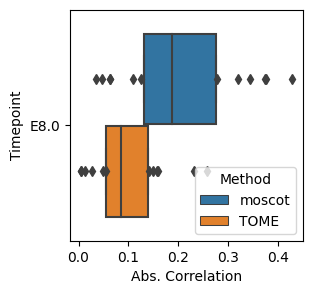

In [13]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax)

In [14]:
DF.to_pickle(f'{Path}/Correlations/{ts0}_SC.npy')